# Experiments

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns

from models import *
from utils import *
from train import *
from bvc import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Approximate BNNs
### Feedforward BNN

In [18]:
X_train, Y_train = load_data('./data/', 'ff_train_abnn_256_0.5_4_5.pkl')
X_test, Y_test = load_data('./data/', 'ff_test_abnn_256_0.5_4_5.pkl')
X_valid, Y_valid = load_data('./data/', 'ff_valid_abnn_256_0.5_4_5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [6]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 5, final eval loss: 0.41823095083236694, time elapsed: 0 h 2 m 44 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.4276036322116852, time elapsed: 0 h 5 m 33 s
3th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.42645274102687836, time elapsed: 0 h 8 m 21 s
4th repeat: best hidden unit: 256, best layers: 5, final eval loss: 0.4382685124874115, time elapsed: 0 h 11 m 9 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.4215661883354187, time elapsed: 0 h 13 m 57 s
6th repeat: best hidden unit: 256, best layers: 5, final eval loss: 0.4378806874155998, time elapsed: 0 h 16 m 44 s
7th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.42620816826820374, time elapsed: 0 h 19 m 34 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.4268849417567253, time elapsed: 0 h 22 m 22 s
9th repeat: best hidden 

Best hidden unit: 256, best layers: 4


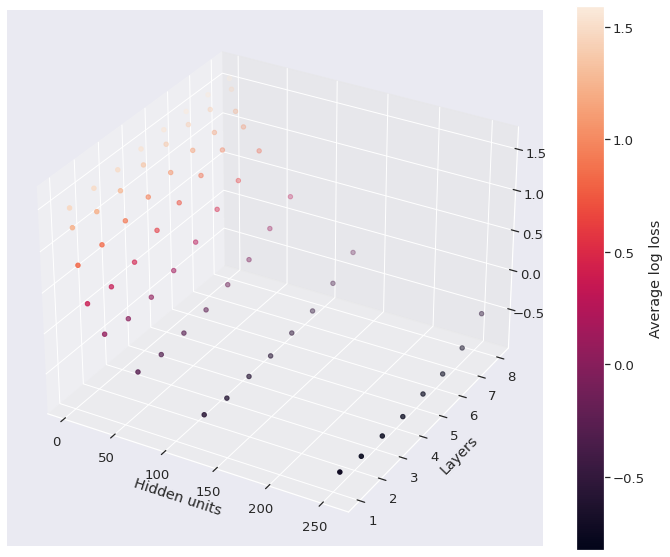

In [7]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_log_ff')

####  2. Learning with best parameter

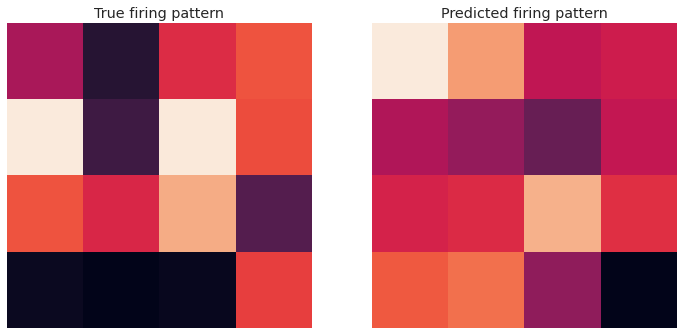

Initial eval loss: 5.023743808269501
Epoch 1: training loss 27.44285362958908, eval loss 1.7013375759124756. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 16.022566825151443, eval loss 1.330637127161026. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 13.086907431483269, eval loss 1.1356037259101868. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 10.580090165138245, eval loss 0.977423682808876. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 8.825427770614624, eval loss 0.758546769618988. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 7.604596063494682, eval loss 1.0028192400932312. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 6.778873577713966, eval loss 0.6104001849889755. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 5.989201202988625, eval loss 0.6066014096140862. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 5.480251178145409, eval loss 0.5094501748681068. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 4.949532680213451, eval loss 0.4988596811890602.

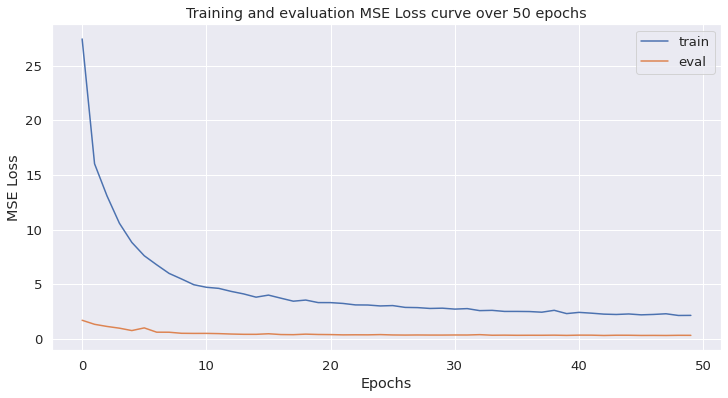

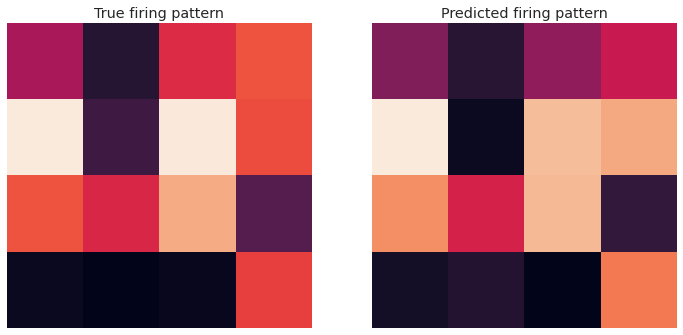

In [20]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [21]:
with torch.no_grad(): 
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.0644, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9990, device='cuda:0')


#### 4. Data efficiency

### Residual BNN

In [10]:
X_train, Y_train = load_data('./data/', 'resid_train_abnn_256_0.5_4_5.pkl')
X_test, Y_test = load_data('./data/', 'resid_test_abnn_256_0.5_4_5.pkl')
X_valid, Y_valid = load_data('./data/', 'resid_valid_abnn_256_0.5_4_5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [11]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.1331539452075958, time elapsed: 0 h 2 m 32 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.0759582370519638, time elapsed: 0 h 5 m 16 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.112314149737358, time elapsed: 0 h 8 m 0 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.1214865893125534, time elapsed: 0 h 10 m 45 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.1162987053394318, time elapsed: 0 h 13 m 32 s
6th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.1327287256717682, time elapsed: 0 h 16 m 18 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.0945728570222855, time elapsed: 0 h 19 m 5 s
8th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.103964164853096, time elapsed: 0 h 21 m 52 s
9th repeat: best hidden unit: 

Best hidden unit: 256, best layers: 3


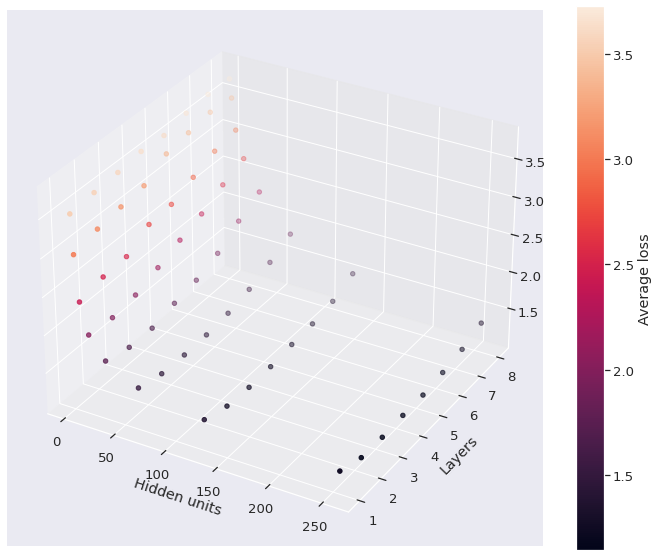

In [22]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_resid')

#### 2. Learning with best parameter

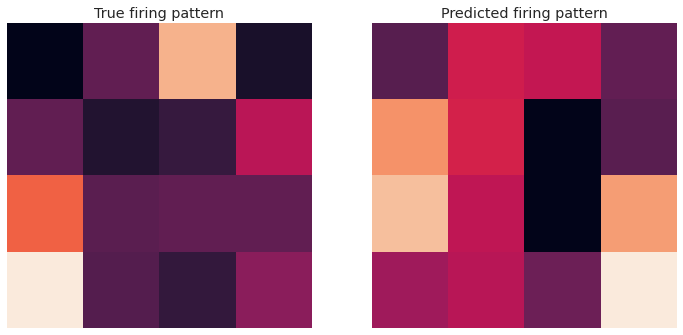

Initial eval loss: 3.7936206459999084
Epoch 1: training loss 27.696831166744232, eval loss 1.9891024231910706. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 20.986399576067924, eval loss 1.6429495811462402. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 18.254225999116898, eval loss 1.4708519876003265. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 16.944531708955765, eval loss 1.368052288889885. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 15.766708105802536, eval loss 1.308748036623001. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 14.779866352677345, eval loss 1.2279099822044373. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 13.998306468129158, eval loss 1.297394335269928. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 13.4624582529068, eval loss 1.1707604378461838. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 12.327529162168503, eval loss 1.1655480861663818. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 11.437696233391762, eval loss 1.14196400344

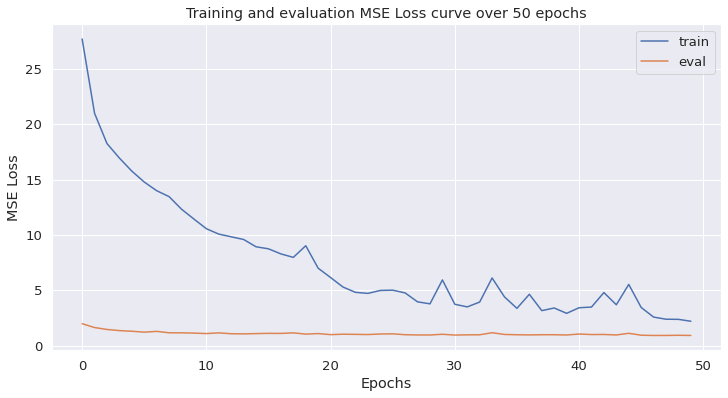

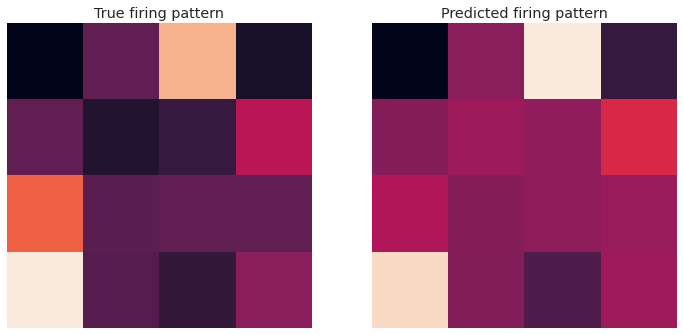

In [13]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [16]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.1856, device='cuda:0')
Predicting mean MSE error on test set tensor(0.7493, device='cuda:0')


### Recurrent BNN

In [2]:
X_train, Y_train = load_data('./data/', 'recur_train_abnn_256_0.5_4_2.pkl')
X_test, Y_test = load_data('./data/', 'recur_test_abnn_256_0.5_4_2.pkl')
X_valid, Y_valid = load_data('./data/', 'recur_valid_abnn_256_0.5_4_2.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Using MLP

##### a) Parameter search

In [4]:
_X_train = X_train.view(-1, 16)
_Y_train = Y_train.view(-1, 16)
_X_test = X_test.view(-1, 16)
_Y_test = Y_test.view(-1, 16)

_train_dataset = BNN_Dataset(_X_train, _Y_train)
_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

_test_dataset = BNN_Dataset(_X_test, _Y_test)
_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 5, final eval loss: 0.6726654320955276, time elapsed: 0 h 3 m 30 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.6706110835075378, time elapsed: 0 h 7 m 8 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.6755398809909821, time elapsed: 0 h 10 m 47 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.6611837446689606, time elapsed: 0 h 14 m 28 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 0.6665671914815903, time elapsed: 0 h 18 m 12 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.6806467771530151, time elapsed: 0 h 21 m 53 s
7th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.6832360774278641, time elapsed: 0 h 25 m 37 s
8th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.6915415525436401, time elapsed: 0 h 29 m 57 s
9th repeat: best hidden un

Best hidden unit: 256, best layers: 4


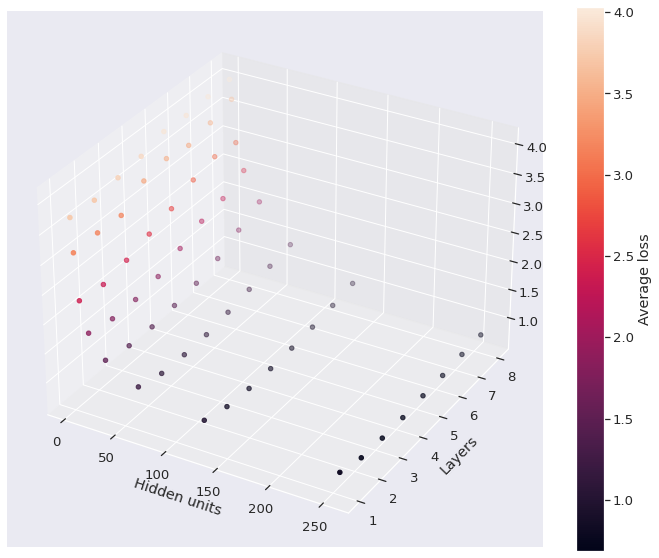

In [8]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_recur_mlp')

##### b) Learning with best parameter

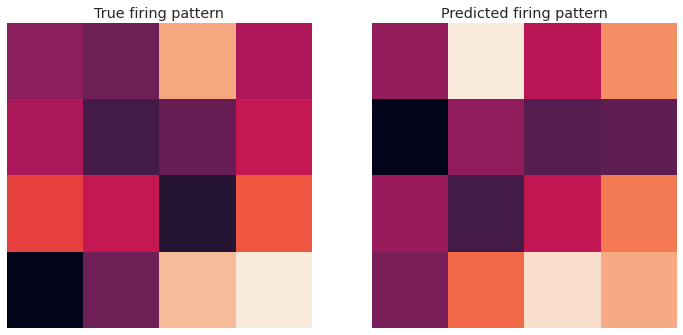

Initial eval loss: 5.009270966053009
Epoch 1: training loss 37.878310680389404, eval loss 3.180839478969574. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 29.264355301856995, eval loss 2.7600595951080322. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 25.811991095542908, eval loss 2.4500575363636017. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 23.49408596754074, eval loss 2.3067101538181305. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 22.121677815914154, eval loss 2.161103308200836. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 21.131865292787552, eval loss 2.110468089580536. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 20.097975432872772, eval loss 2.0116077065467834. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 19.46326634287834, eval loss 1.989150583744049. Time elapsed: 0 h 0 m 2 s.
Epoch 9: training loss 18.92202752828598, eval loss 1.8896190226078033. Time elapsed: 0 h 0 m 2 s.
Epoch 10: training loss 18.34282684326172, eval loss 1.852342456579208

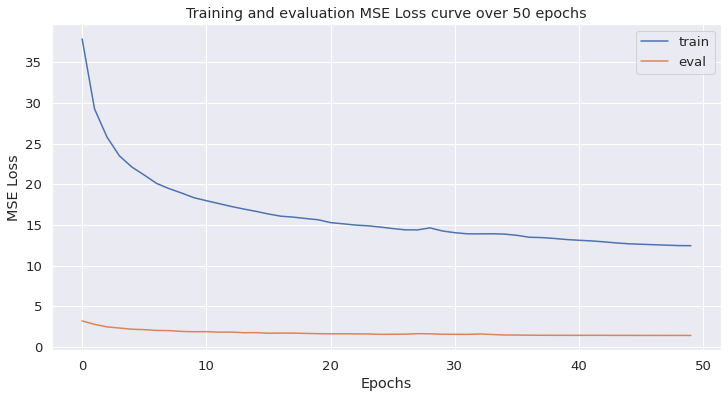

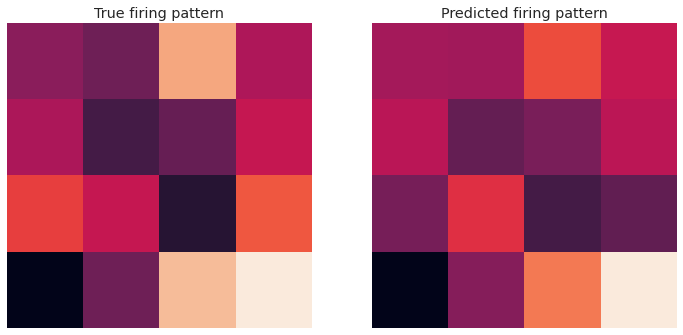

In [12]:
v_idx = np.random.randint(0, len(_Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(_Y_test[v_idx,:], DNN(_X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=_train_dataloader, test_loader=_test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(_Y_test[v_idx,:], DNN(_X_test[v_idx,:])) # visualise after training

##### c) Testing against predicting the mean

In [13]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(_X_test), _Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(_Y_test, dim=0).repeat([50000,1]), _Y_test))

DNN prediction MSE error on test set:  tensor(0.2782, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9990, device='cuda:0')


#### 2. Using RNN

##### a) Parameter search

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.1775511652231216, time elapsed: 0 h 3 m 14 s
2th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.1685474514961243, time elapsed: 0 h 6 m 33 s
3th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.1775284111499786, time elapsed: 0 h 10 m 6 s
4th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.1772110909223557, time elapsed: 0 h 13 m 38 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.1891040056943893, time elapsed: 0 h 17 m 11 s
6th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.182258516550064, time elapsed: 0 h 20 m 44 s
7th repeat: best hidden unit: 256, best layers: 8, final eval loss: 1.1878353208303452, time elapsed: 0 h 24 m 20 s
8th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.1775005161762238, time elapsed: 0 h 27 m 55 s
9th repeat: best hidden uni

Best hidden unit: 256, best layers: 2


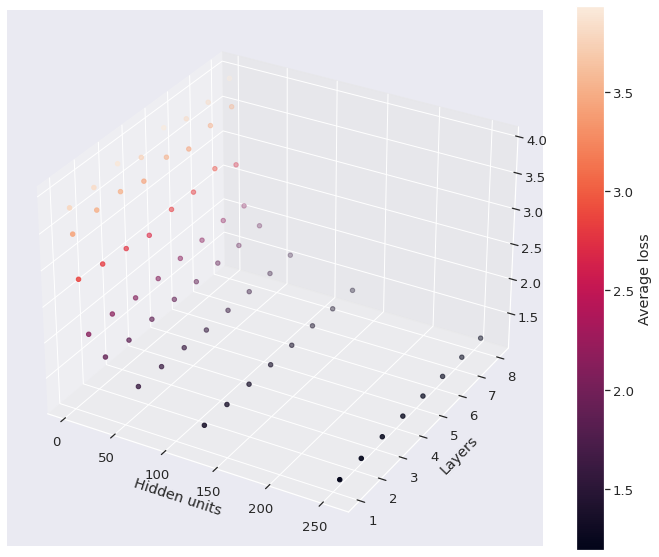

In [10]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_recur_lstm')

##### b) Learning with best parameter

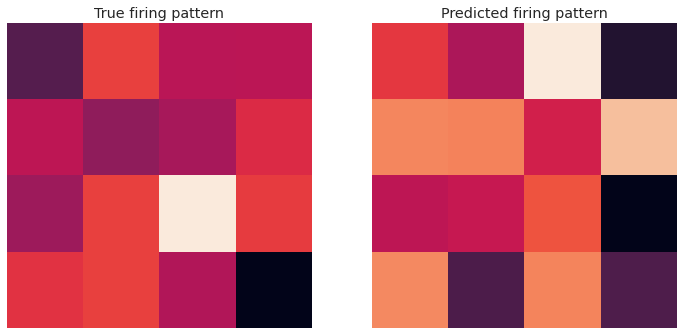

Initial eval loss: 13.928428411483765
Epoch 1: training loss 42.69041097164154, eval loss 2.4860836267471313. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 21.867699712514877, eval loss 2.0355549454689026. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 19.862395584583282, eval loss 1.9043523967266083. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 18.50702866911888, eval loss 1.7685088515281677. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 17.122821420431137, eval loss 1.6380216181278229. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 15.963249117136002, eval loss 1.5424688458442688. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 15.143390417098999, eval loss 1.474016159772873. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 14.52387660741806, eval loss 1.4215799868106842. Time elapsed: 0 h 0 m 1 s.
Epoch 9: training loss 14.04197233915329, eval loss 1.3792876303195953. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 13.64703443646431, eval loss 1.344130426645

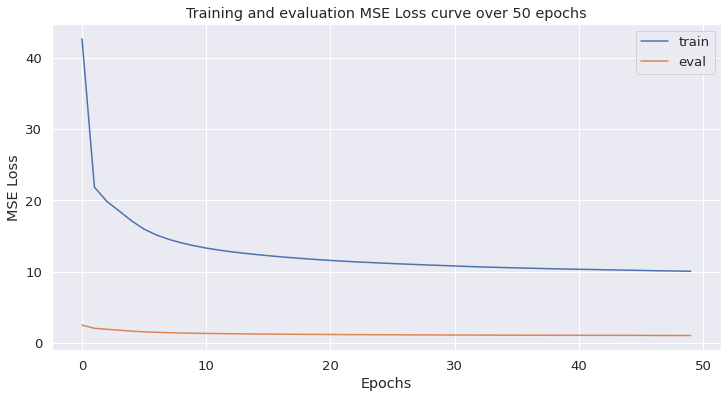

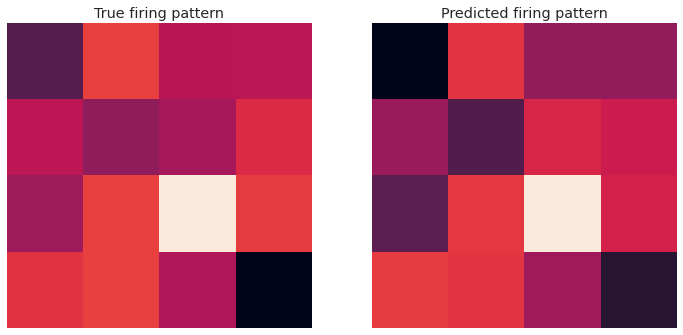

In [5]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=2, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

##### c) Testing against predicting the mean

In [ ]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

### Complex BNN

In [8]:
X_train, Y_train = load_data('./data/', 'cplx_train_abnn_256_0.5_4_2.pkl')
X_test, Y_test = load_data('./data/', 'cplx_test_abnn_256_0.5_4_2.pkl')
X_valid, Y_valid = load_data('./data/', 'cplx_valid_abnn_256_0.5_4_2.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Using MLP

##### a) Parameter search

In [9]:
_X_train = X_train.view(-1, 16)
_Y_train = Y_train.view(-1, 16)
_X_test = X_test.view(-1, 16)
_Y_test = Y_test.view(-1, 16)

_train_dataset = BNN_Dataset(_X_train, _Y_train)
_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

_test_dataset = BNN_Dataset(_X_test, _Y_test)
_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.6334381699562073, time elapsed: 0 h 3 m 6 s
2th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.638429969549179, time elapsed: 0 h 6 m 28 s
3th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.6217858791351318, time elapsed: 0 h 9 m 54 s
4th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.620465338230133, time elapsed: 0 h 13 m 20 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.6113952994346619, time elapsed: 0 h 16 m 46 s
6th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.6455354988574982, time elapsed: 0 h 20 m 11 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6276245415210724, time elapsed: 0 h 23 m 42 s
8th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.6216606497764587, time elapsed: 0 h 27 m 11 s
9th repeat: best hidden unit:

Best hidden unit: 256, best layers: 5


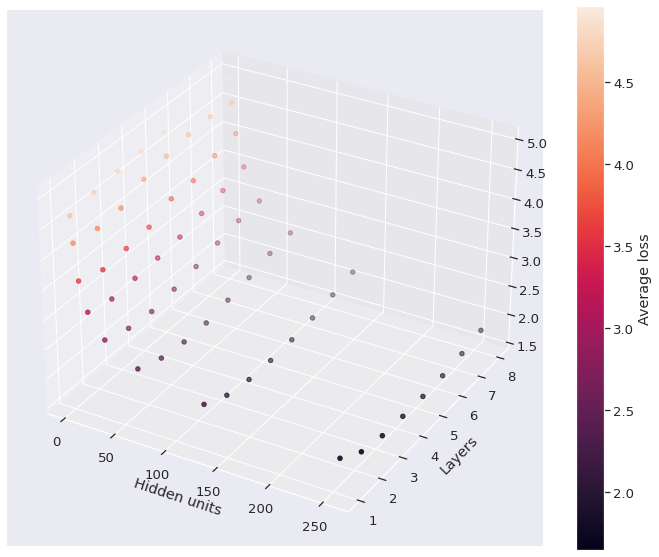

In [17]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_cplx_mlp')

##### b) Learning with best parameter

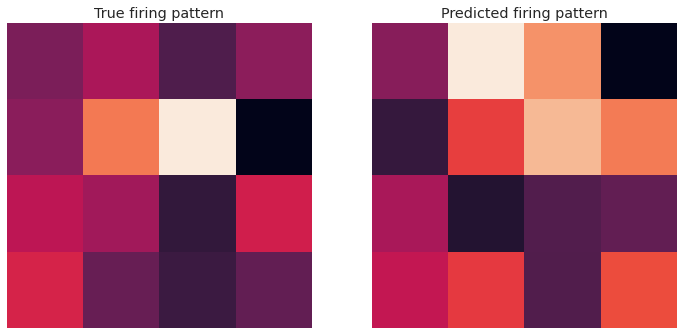

Initial eval loss: 5.003140091896057
Epoch 1: training loss 39.05329781770706, eval loss 3.2525264024734497. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 30.54826045036316, eval loss 2.8217371106147766. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 26.89721754193306, eval loss 2.5575561225414276. Time elapsed: 0 h 0 m 1 s.
Epoch 4: training loss 24.269365459680557, eval loss 2.333580821752548. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 22.579109638929367, eval loss 2.225007563829422. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 21.68133771419525, eval loss 2.1058585047721863. Time elapsed: 0 h 0 m 2 s.
Epoch 7: training loss 20.35234495997429, eval loss 2.0240684747695923. Time elapsed: 0 h 0 m 2 s.
Epoch 8: training loss 19.688942670822144, eval loss 1.984620988368988. Time elapsed: 0 h 0 m 2 s.
Epoch 9: training loss 19.175301492214203, eval loss 1.9349365234375. Time elapsed: 0 h 0 m 3 s.
Epoch 10: training loss 18.721136271953583, eval loss 1.9466700851917267. 

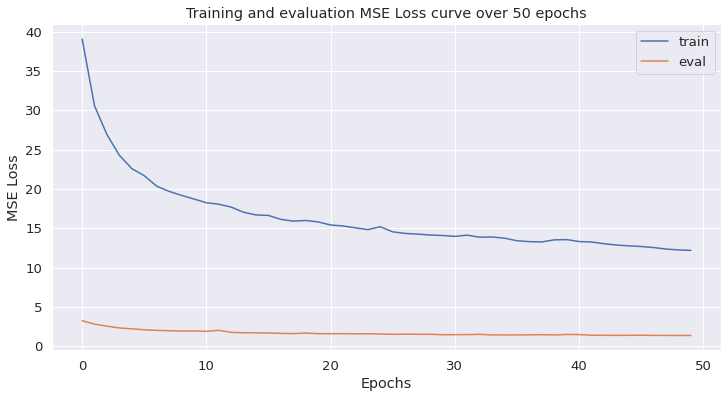

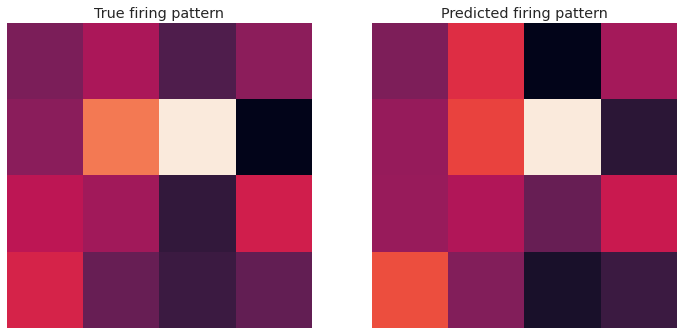

In [14]:
v_idx = np.random.randint(0, len(_Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=5, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(_Y_test[v_idx,:], DNN(_X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=_train_dataloader, test_loader=_test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(_Y_test[v_idx,:], DNN(_X_test[v_idx,:])) # visualise after training

##### c) Testing against predicting the mean

In [15]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(_X_test), _Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(_Y_test, dim=0).repeat([50000,1]), _Y_test))

DNN prediction MSE error on test set:  tensor(0.2763, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9990, device='cuda:0')


#### 2. Using RNN

##### a) Parameter search

In [18]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 8, final eval loss: 2.4363931119441986, time elapsed: 0 h 3 m 22 s
2th repeat: best hidden unit: 256, best layers: 8, final eval loss: 2.4440633356571198, time elapsed: 0 h 6 m 43 s
3th repeat: best hidden unit: 256, best layers: 1, final eval loss: 2.451149493455887, time elapsed: 0 h 10 m 3 s
4th repeat: best hidden unit: 256, best layers: 5, final eval loss: 2.438492029905319, time elapsed: 0 h 13 m 25 s
5th repeat: best hidden unit: 256, best layers: 3, final eval loss: 2.4450211822986603, time elapsed: 0 h 16 m 52 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 2.451535016298294, time elapsed: 0 h 20 m 15 s
7th repeat: best hidden unit: 256, best layers: 2, final eval loss: 2.433274507522583, time elapsed: 0 h 23 m 35 s
8th repeat: best hidden unit: 256, best layers: 8, final eval loss: 2.4537006616592407, time elapsed: 0 h 26 m 53 s
9th repeat: best hidden unit: 

Best hidden unit: 256, best layers: 8


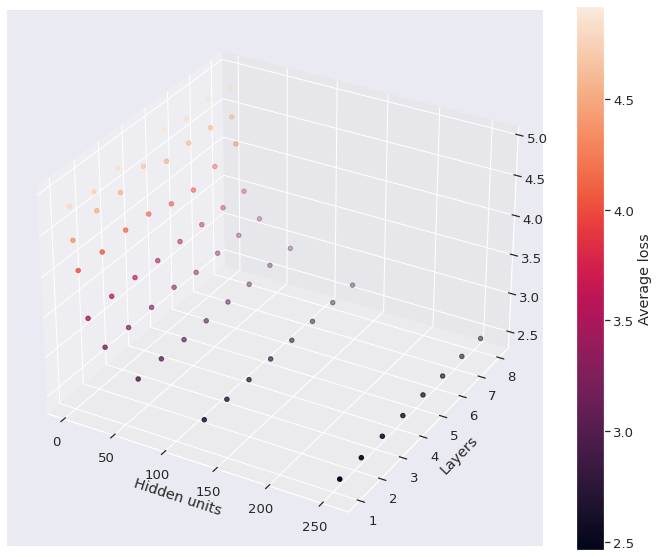

In [19]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_cplx_lstm')

##### b) Learning with best parameter

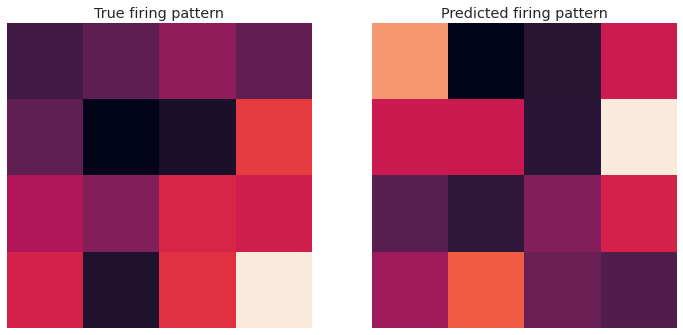

Initial eval loss: 12.18337869644165
Epoch 1: training loss 51.16990464925766, eval loss 3.759162127971649. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 35.44161468744278, eval loss 3.401367962360382. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 33.057405948638916, eval loss 3.208690822124481. Time elapsed: 0 h 0 m 1 s.
Epoch 4: training loss 31.293284714221954, eval loss 3.0574206709861755. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 30.04375296831131, eval loss 2.9606348872184753. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 29.24308717250824, eval loss 2.8941116333007812. Time elapsed: 0 h 0 m 2 s.
Epoch 7: training loss 28.64031171798706, eval loss 2.8398541808128357. Time elapsed: 0 h 0 m 2 s.
Epoch 8: training loss 28.129880726337433, eval loss 2.793581545352936. Time elapsed: 0 h 0 m 3 s.
Epoch 9: training loss 27.69814282655716, eval loss 2.7533832788467407. Time elapsed: 0 h 0 m 3 s.
Epoch 10: training loss 27.30478858947754, eval loss 2.7158236503601074. 

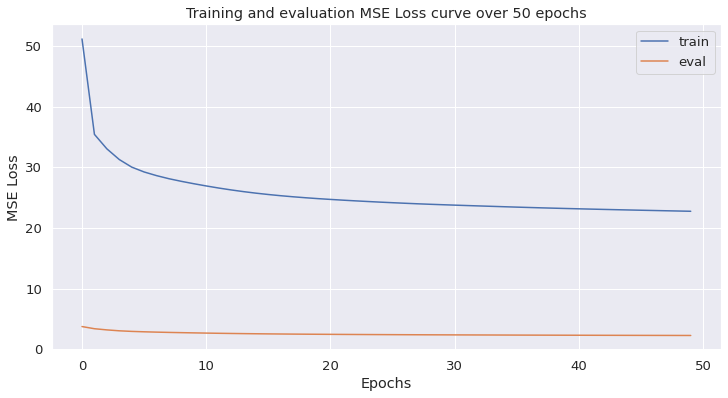

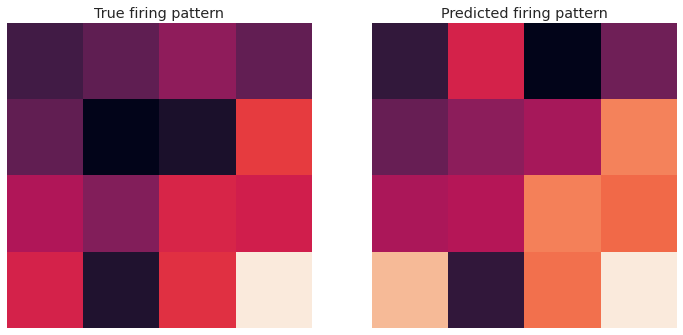

In [16]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=8, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

##### c) Testing against predicting the mean

In [17]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set:  tensor(0.4576, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9990, device='cuda:0')


## BVC Simulation

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns

from models import *
from utils import *
from train import *
from bvc import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

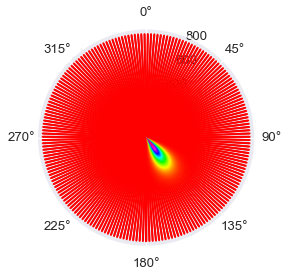

tensor([6.7310e-05])

In [2]:
l = 80
w = 80
env = RectangleEnvironment(l, w)
bvc1 = BVC(80, 0*torch.pi)
bvc2 = BVC(50, 1/2*torch.pi)
bvc3 = BVC(50, 0.8*torch.pi)
plot_bvc_firing_field([bvc3], max_d=800)
distances, bearings, angles = env.compute_wall_dist((70,50))
bvc3.obtain_net_firing_rate(distances, bearings, angles)

/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2890.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


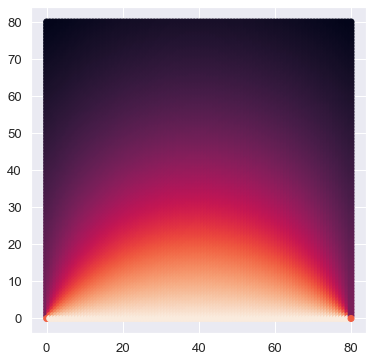

In [3]:
env.visualise_bvc_firing_rate(bvc3)